# Install Packages and call functions

In [96]:
#!pip install python_speech_features
#!pip install jiwer
#!pip install mega.py

In [97]:
import os
import numpy as np
import pandas as pd
from mega import Mega
import matplotlib.pyplot as plt
from IPython import display

from scipy.io import wavfile
import soundfile as sf
from scipy import signal
import python_speech_features
from jiwer import wer
import itertools



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from typing import List, Callable, Tuple

# Data processing

In [ ]:
#!wget http://206.12.93.90:8080/LJSpeech-1.1/LJSpeech-1.1.tar.gz
#!tar -xzvf  LJSpeech-1.1.tar.gz 2> /dev/null
#!rm LJSpeech-1.1.tar.gz

In [ ]:
df = pd.read_csv('LJSpeech-1.1/metadata.csv', sep='|', header=None)
df.columns = ["filename", "transcript", "col3"]
df = df[["filename", "transcript"]]
df.head(3)

filename                                         transcript
0  LJ001-0001  Printing, in the only sense with which we are ...
1  LJ001-0002                     in being comparatively modern.
2  LJ001-0003  For although the Chinese took impressions from...

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, batch_size=32):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.char_mapping = {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10,
                'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20,
                'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, "'": 27,'': 28}
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        audios, labels = self.__data_generation(batch_data)
        return audios, labels

        'text processing'
    def text_to_idx(self, text):
        text  = text.lower()
        idx = []
        for chr in text:
            if chr in self.char_mapping :
                idx.append(self.char_mapping[chr])
        return idx
          
        'normalize raw audio'
                
    def normalize(self, audio):
        gain = 1.0 / (np.max(np.abs(audio)) + 1e-5)
        return audio * gain
        
        'standardize FBANK'
    def standardize(self,features):
        mean = np.mean(features)
        std = np.std(features)
        return (features - mean) / std
        
        'FBAnk processing'
    def audio_to_features(self, audio):
        sf, audio = wavfile.read(f"./LJSpeech-1.1/wavs/{audio}.wav")
        audio = self.normalize(audio.astype(np.float32))
        audio = (audio * np.iinfo(np.int16).max).astype(np.int16)
        feat, energy = python_speech_features.fbank(
            audio, nfilt=160, winlen=0.02,winstep=0.01, winfunc = np.hanning)
        features = np.log(feat)
        return  self.standardize(features)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))

    def __data_generation(self, batch_data):
        audios = []
        labels = []
        label_len = []
        audio_len = []

        for filename, transcript in batch_data:
            audio = self.audio_to_features(filename)
            audios.append(audio)
            audio_len.append(len(audio))

            label = self.text_to_idx(transcript)
            labels.append(label)
            label_len.append(len(label))
            
        max_audio_len = max(audio_len)
        max_label_len = max(label_len)
        audios = pad_sequences(audios, maxlen = max_audio_len, dtype='float32', value=0, padding='post')
        labels = pad_sequences(labels, maxlen = max_label_len, value=28, padding='post')
        return audios, labels
split = int(len(df)*0.99)
df_train = df[:split]
df_val = df[split:]

In [ ]:
training_gen = DataGenerator(df_train)
valid_gen = DataGenerator(df_val)

# Visualization

 Example 1
  - Speech audio 1


  - Transcript: Manpower and Technical Assistance From Other Agencies


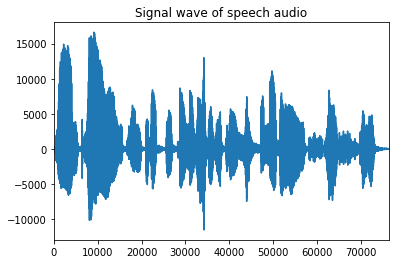

 Example 2
  - Speech audio 2


  - Transcript: This Commission can recommend no procedures for the future protection of our Presidents which will guarantee security.


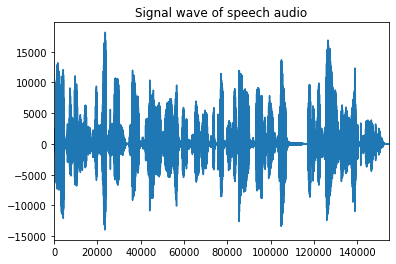

In [135]:
for j, i in enumerate(np.random.randint(0, len(df_val), 2)):
    print(f"\033[1m Example {j+1}")
    
    #Speech sound
    filename = df_val["filename"].iloc[i]
    sf, audio = wavfile.read(f"./LJSpeech-1.1/wavs/{filename}.wav")
  
    print(f"\033[0m  - Speech audio {j+1}")
    display.display(display.Audio(np.transpose(audio), rate=16000))
    transcript = df_val["transcript"].iloc[i]
    print(f"\033[0m  - Transcript: {transcript}")
    plt.plot(audio)
    plt.title("Signal wave of speech audio")
    plt.xlim(0, len(audio))
    plt.show()

# Model

In [ ]:
def Deep_Speech(input_dim = 160, rnn_layers = 5, rnn_units = 512, output_dim = 29):
    input = layers.Input([None, input_dim], name='input')
    x = layers.Lambda(K.expand_dims,arguments=dict(axis=-1), name = "expand_dim")(input)
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding='same', use_bias=False, name='conv_1')(x)
    x = layers.BatchNormalization(name='conv_1_bn')(x)
    x = layers.ReLU(name='conv_1_relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding='same', use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(name='conv_2_bn')(x)
    x = layers.ReLU(name='conv_2_relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=[11, 21], strides=[1, 2], padding='same', use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(name='conv_3_bn')(x)
    x = layers.ReLU(name='conv_3_relu')(x)
    x = layers.Reshape([-1, input_dim//4*32])(x)
    for i in range(1, rnn_layers+1):
        recurrent = layers.GRU(units = rnn_units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True, reset_after=True, name=f'gru_{i}')
        x = layers.Bidirectional(recurrent, name=f'bidirectional_{i}',merge_mode='concat')(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.TimeDistributed(layers.Dense(units=rnn_units*2), name='dense_1')(x)
    x = layers.ReLU(name='dense_1_relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    output = layers.TimeDistributed(layers.Dense(units=output_dim), name='output')(x)
    model = tf.keras.Model(input, output, name='DeepSpeech2')
    return model

In [ ]:
 # CTC loss
 def get_loss() -> Callable:
        """ The CTC loss using TensorFlow's `ctc_loss`. """
        def get_length(tensor):
            lengths = tf.math.reduce_sum(tf.ones_like(tensor), 1)
            return tf.cast(lengths, tf.int32)

        def ctc_loss(labels, logits):
            label_length = get_length(labels)
            logit_length = get_length(tf.math.reduce_max(logits, 2))
            labels = tf.cast(labels, tf.int32)
            return tf.nn.ctc_loss(labels, logits, label_length, logit_length,
                                  logits_time_major=False, blank_index=-1)
        return ctc_loss
loss = get_loss()
optimizer = tf.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

In [ ]:
#Compile model
model = Deep_Speech(input_dim=160, output_dim=29,rnn_units=800)
model.compile(optimizer = optimizer, loss = loss)

#Training

In [ ]:
batch_size = 32
class callback(keras.callbacks.Callback):

    def __init__(self,dataset):
        super().__init__()
        self.dataset = dataset
        self.idx_mapping = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '']

    def GreedyDecoder(self, batch_logits):
        best_candidates = np.argmax(batch_logits, axis=2)
        #remove  repeated
        decoded = [np.array([k for k, _ in itertools.groupby(best_candidate)]) for best_candidate in best_candidates]
        return decoded

    def get_batch_transcripts(self,sequences):
        return [''.join(self.idx_mapping[char_label] for char_label in sequence if char_label not in (-1, 28)) for sequence in sequences]

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
          X, y = batch
          batch_logits = model.predict(X)
          decoded_labels = self.GreedyDecoder(batch_logits)
          batch_predictions = self.get_batch_transcripts(decoded_labels)
          batch_transcripts = ["".join([self.idx_mapping[i] for i in label]) for label in y]
          
          predictions.extend(batch_predictions)
          targets.extend(batch_transcripts)
        wer_score = wer(targets, predictions)
        print("\n")
        print(f"WER SCORE: {wer_score}")
        print("*"*15)
        for i in np.random.randint(0, 32, 2):
          print(f"Transcript: {targets[i]}")
          print(f"prediction: {predictions[i]}")
          print("*"*15)
          
callback = callback(valid_gen)

In [ ]:
History = model.fit(training_gen,
          validation_data =valid_gen,
          epochs = 1,
          callbacks = [callback])

405/405 [==============================] - 1455s 4s/step - loss: 220.4571 - val_loss: 167.5731


WER SCORE: 0.9081632653061225
***************
Transcript: the commission further recommends that the secret service coordinate its planning as closely as possible with all of the federal agencies from which it receives information
prediction: the commion frthereormbnst the sereiserpiscrn i plne is cosly is psbl witl theeraens frwicrfr'
***************
Transcript: since the assassination secret service procedures have been changed to require that a member of prs accompany each advance survey team
prediction: snte ssinion sereseris prters  ben to  tat a meber prs popb tobas ser
***************


# Evaluation

In [ ]:
#Download the weight trained by 30 epochs
mega = Mega()
m = mega.login()
m.download_url("https://mega.nz/file/kwkQFIjL#rzxpfMvtG68ehElDwJ8tsvAzR8JIYUwGa_FofMdyKqk")

PosixPath('DeepSpeech2.h5')

In [ ]:
print("Load model")
model.load_weights("DeepSpeech2.h5")

Load model


In [ ]:
idx_mapping = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '']

def GreedyDecoder(batch_logits):
    best_candidates = np.argmax(batch_logits, axis=2)
    #remove  repeated
    decoded = [np.array([k for k, _ in itertools.groupby(best_candidate)]) for best_candidate in best_candidates]
    return decoded

def get_batch_transcripts(sequences):
    return [''.join(idx_mapping[char_label] for char_label in sequence if char_label not in (-1, 28)) for sequence in sequences]

In [ ]:
def evaluate(model, dataset):
    loss = model.evaluate(dataset)
    predictions = []
    targets = []
    batch_num = 1
    mean_wer = 0
    for batch in dataset:
        X, y = batch
        batch_logits = model.predict(X)
        decoded_labels = GreedyDecoder(batch_logits)
        batch_predictions = get_batch_transcripts(decoded_labels)
        batch_transcripts = ["".join([idx_mapping[i] for i in label]) for label in y]
        
        predictions.extend(batch_predictions)
        targets.extend(batch_transcripts)
        wer_score = wer(batch_transcripts, batch_predictions)
        mean_wer += wer_score
        batch_num += 1
    mean_wer = mean_wer/batch_num
    print(f"\033[1m CTC LOSS: {round(loss, 2)} \033[0m")
    print(f"\033[1m WER: {int(wer_score*100)}% \033[0m")
    print("*"*70)
    for i in np.random.randint(0, len(predictions), 5):
        print(f"\033[1m Transcript: \033[0m {targets[i]}")
        print(f"\033[1m prediction: \033[0m {predictions[i]}")
        print("*"*70)
    return loss, mean_wer

In [ ]:
#Evaluate the model on the training set
evaluate(model, training_gen)

405/405 [==============================] - 928s 2s/step - loss: 9.4836
 CTC LOSS: 9.48 
 WER: 6% 
**********************************************************************
 Transcript:  on the other hand those plants such as the fungi
 prediction:  on the other hand those plants such as the fungi''
**********************************************************************
 Transcript:  although oswald destroyed the notebook three photographs found among oswald's possessions after the assassination
 prediction:  although oswald destroyed the notebook three photographs found among oswald's possessions after the assassination''
**********************************************************************
 Transcript:  he suffered at stafford in front of the jail
 prediction:  he suffered at stafford in front of the jail''
**********************************************************************
 Transcript:  macintosh's amendment was carried in the commons but the new law did not pass the lords who reenac

In [ ]:
#Evaluate the model on the validation set
evaluate(model, valid_gen)

4/4 [==============================] - 9s 2s/step - loss: 39.1392
 CTC LOSS: 39.14 
 WER: 14% 
**********************************************************************
 Transcript:  the secret service should utilize the personnel of other federal law enforcement offices
 prediction:  the secret service should utilize the personnel of other federal law enforcement offices'
**********************************************************************
 Transcript:  it may eventually be desirable to codify the practice in an executive order
 prediction:  it may eventually be desirable to coatify the practice in an executive order'
**********************************************************************
 Transcript:  in case of unexpected need and  additional agents are recommended to provide the vice president full protection
 prediction:  in case of unexpected need and twentyfive additional agents are recommended to provide the vice president full protection'
****************************************

# Add Noise Background

In this section, we will add some noise in critical-mission areas such as war and hospital to find  out how will the noise affect the system.


## Noise Data processing

In [123]:
class NoiseDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, noise_sound, batch_size=32, noise_rate = 0.1):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.noise_sound = noise_sound
        self.noise_rate = noise_rate
        self.char_mapping = {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10,
                'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20,
                'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, "'": 27,'': 28}
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        audios, labels = self.__data_generation(batch_data)
        return audios, labels

        'text processing'
    def text_to_idx(self, text):
        text  = text.lower()
        idx = []
        for chr in text:
            if chr in self.char_mapping :
                idx.append(self.char_mapping[chr])
        return idx
        'normalize raw audio'
                
    def normalize(self, audio):
        gain = 1.0 / (np.max(np.abs(audio)) + 1e-5)
        return audio * gain
        
        'standardize FBANK'
    def standardize(self,features):
        mean = np.mean(features)
        std = np.std(features)
        return (features - mean) / std
        
        'FBAnk processing'
    def audio_to_features(self, audio):
        #Load speech sound 
        sf, audio = wavfile.read(f"./LJSpeech-1.1/wavs/{audio}.wav")
        #Trim battle sound
        i = np.random.randint(int(len(self.noise_sound) - len(audio)))
        try:
          trim_audio = self.noise_sound[i:i+len(audio)][:, 0]
        except:
          trim_audio = self.noise_sound[i:i+len(audio)]
        #Add noise sound to speech sound
        audio =  audio*(1-self.noise_rate) + trim_audio*self.noise_rate
        audio = self.normalize(audio.astype(np.float32))
        audio = (audio * np.iinfo(np.int16).max).astype(np.int16)
        feat, energy = python_speech_features.fbank(
            audio, nfilt=160, winlen=0.02,winstep=0.01, winfunc = np.hanning)
        features = np.log(feat)
        return  self.standardize(features)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))

    def __data_generation(self, batch_data):
        audios = []
        labels = []
        label_len = []
        audio_len = []

        for filename, transcript in batch_data:
            audio = self.audio_to_features(filename)
            audios.append(audio)
            audio_len.append(len(audio))

            label = self.text_to_idx(transcript)
            labels.append(label)
            label_len.append(len(label))
            
        max_audio_len = max(audio_len)
        max_label_len = max(label_len)
        audios = pad_sequences(audios, maxlen = max_audio_len, dtype='float32', value=0, padding='post')
        labels = pad_sequences(labels, maxlen = max_label_len, value=28, padding='post')
        return audios, labels
split = int(len(df)*0.99)
df_train = df[:split]
df_val = df[split:]

## Add Battle Background Sound

### Visualize battle background sound

In [ ]:
#Download Battle sound
m.download_url("https://mega.nz/file/I0EHTITQ#sIORKEj-eMcKyBrW4LLOPU4zsUpBwL-uKTXjvvNKdb4")
sf, battle_sound = wavfile.read("battle_sound.wav")

PosixPath('battle_sound.wav')

noise_rate is the rate to merge 2 audios together. If we increase the noise_rate high, the battle's voice is louder and vice versa.

In [136]:
def visualization_noise(noise_sound):
    noise_rates = [0.1, 0.5,0.9]
    i = np.random.randint(0, len(df_val))
    #Speech sound
    filename = df_val["filename"].iloc[i]
    sf, audio = wavfile.read(f"./LJSpeech-1.1/wavs/{filename}.wav")
  
    print(f"\033[1m  - Speech audio")
    display.display(display.Audio(np.transpose(audio), rate=16000))
    transcript = df_val["transcript"].iloc[i]
    print(f"\033[1m  - Transcript: {transcript}")
    plt.plot(audio)
    plt.title("Signal wave of speech audio")
    plt.xlim(0, len(audio))
    plt.show()
    
    #Trim the noise sound
    i = np.random.randint(int(len(noise_sound) - len(audio)))
    try:
      noise_trim = noise_sound[i:i+len(audio)][:, 0]
    except:
      noise_trim = noise_sound[i:i+len(audio)]

    print("\033[1m  - Noise audio")
    display.display(display.Audio(np.transpose(noise_trim), rate=16000))
    plt.plot(noise_trim)
    plt.title("Signal wave of Noise sound")
    plt.xlim(0, len(noise_trim))
    plt.show()
    
    #Add battle backround to speech
    for noise_rate in noise_rates:
        mix_audio =  audio*(1-noise_rate) + noise_trim*noise_rate
        print(f"\033[1m  - Mixed audio with noise_rate = {noise_rate}")
        plt.plot(mix_audio)
        plt.title("Signal Wave of mixed audio")
        plt.xlim(0, len(mix_audio))
        display.display(display.Audio(np.transpose(mix_audio), rate=16000))
        plt.show()

  - Speech audio


  - Transcript: the increased information supplied by other agencies will be wasted.


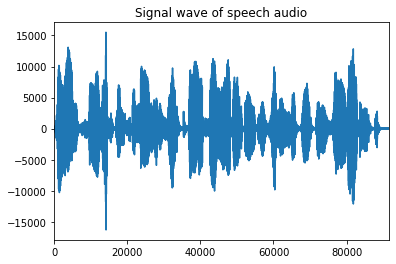

  - Noise audio


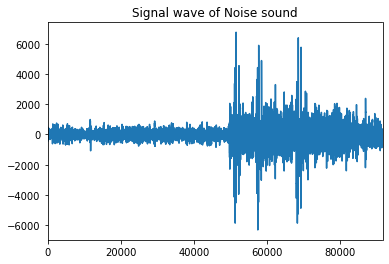

  - Mixed audio with noise_rate = 0.1


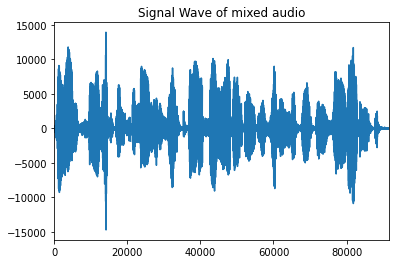

  - Mixed audio with noise_rate = 0.5


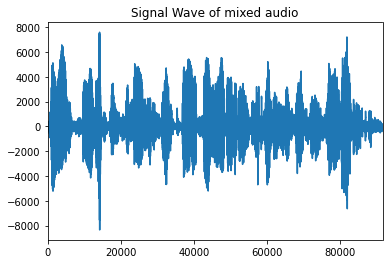

  - Mixed audio with noise_rate = 0.9


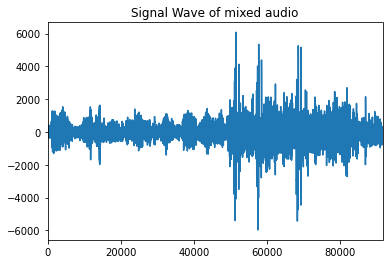

In [137]:
visualization_noise(battle_sound)

### Evaluation

In [89]:
noise_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
losses = []
wers = []
for noise_rate in noise_rates:
  print(f"\033[1m EVALUATE THE MODEL WITH NOISE_RATE = {noise_rate} \033[0m")
  valid_gen_noise = NoiseDataGenerator(df_val, battle_sound, noise_rate = noise_rate)
  loss, wer_score = evaluate(model, valid_gen_noise)
  losses.append(loss)
  wers.append(wer_score)
  print("\n")


 EVALUATE THE MODEL WITH NOISE_RATE = 0 
4/4 [==============================] - 10s 2s/step - loss: 39.1392
 CTC LOSS: 39.14 
 WER: 14% 
**********************************************************************
 Transcript:  and the traditions of the office in a democracy such as ours are so deepseated as to preclude absolute security
 prediction:  and the traditions of the office in a democracy such as hours are so deepseated as to preclude absolute security'
**********************************************************************
 Transcript:  but it seems to warrant further study before each agency becomes irrevocably committed to separate action
 prediction:  but it seems to wart further study before each agency becomes irrevocably committed to separate action'
**********************************************************************
 Transcript:  protecting the president is a difficult and complex task which requires full use of the best resources of many parts of our government
 predicti

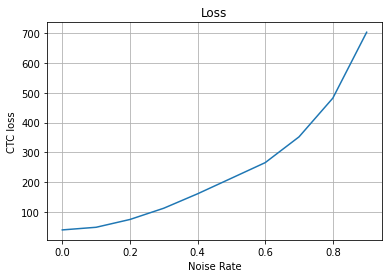

In [72]:
plt.plot(noise_rates, losses)
plt.title("Loss")
plt.xlabel("Noise Rate")
plt.ylabel("CTC loss")
plt.grid()
plt.show()

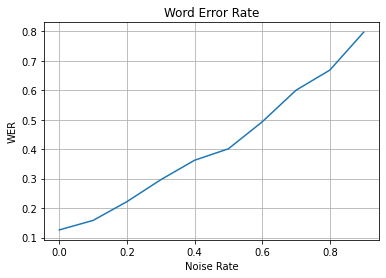

In [71]:
plt.plot(noise_rates, wers)
plt.title("Word Error Rate")
plt.xlabel("Noise Rate")
plt.ylabel("WER")
plt.grid()
plt.show()

## Add Hospital Background sound

### Add Heartbeat Sound

#### Visualize battle background sound

In [112]:
#Download heartbeat sound
m.download_url("https://mega.nz/file/A1s2UaIb#2OMa7V2qw19fNu-ORYb9v-aK_Eavpl-ubeJ7EXPW064")
sf, heartbeat_sound = wavfile.read("heartbeat_sound.wav")

PosixPath('heartbeat_sound.wav')

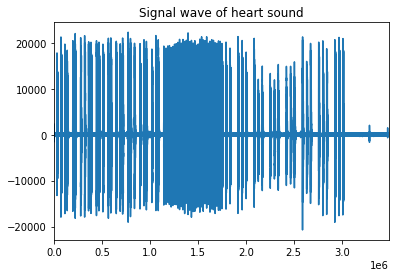

In [115]:
plt.plot(heartbeat_sound)
plt.title("Signal wave of heart sound")
plt.xlim(0, len(heartbeat_sound))
plt.show()

  - Speech audio


  - Transcript: This Commission can recommend no procedures for the future protection of our Presidents which will guarantee security.


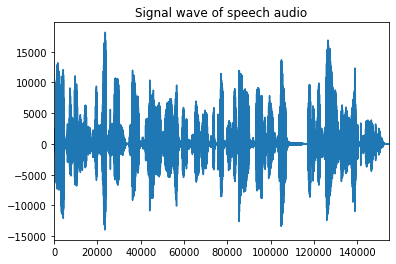

  - Noise audio


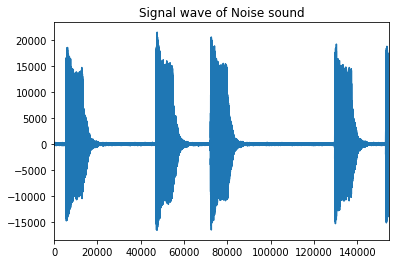

  - Mixed audio with noise_rate = 0.1


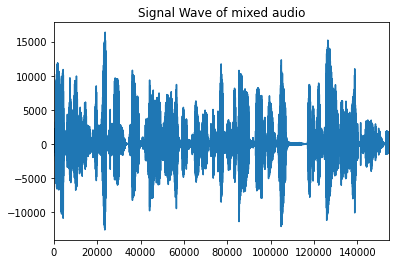

  - Mixed audio with noise_rate = 0.5


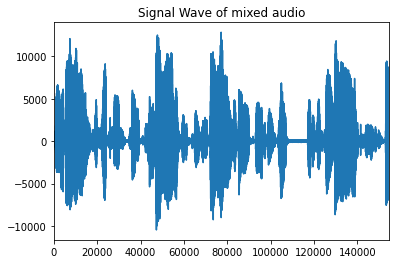

  - Mixed audio with noise_rate = 0.9


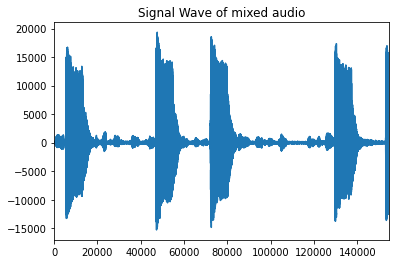

In [138]:
visualization_noise(heartbeat_sound)

#### Evaluation

In [125]:
noise_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
losses = []
wers = []
for noise_rate in noise_rates:
  print(f"\033[1m EVALUATE THE MODEL WITH NOISE_RATE = {noise_rate} \033[0m")
  valid_gen_noise = NoiseDataGenerator(df_val, heartbeat_sound, noise_rate = noise_rate)
  loss, wer_score = evaluate(model, valid_gen_noise)
  losses.append(loss)
  wers.append(wer_score)
  print("\n")

 EVALUATE THE MODEL WITH NOISE_RATE = 0 
4/4 [==============================] - 9s 2s/step - loss: 39.1392
 CTC LOSS: 39.14 
 WER: 14% 
**********************************************************************
 Transcript:  even though it agrees with the secret service that it is preferable for the service to have enough agents to handle all protective demands
 prediction:  even though at agrees with the secreservice that it is preferable for the service to have enough agents to handle all protective demands
**********************************************************************
 Transcript:  this matter is obviously beyond the jurisdiction of the commission
 prediction:  this matter is obbiously abeyond the jurisdiction of the commission''
**********************************************************************
 Transcript:  that coordination might be achieved to a greater extent than seems now to be contemplated without interference with the primary mission of each agency involved
 predict

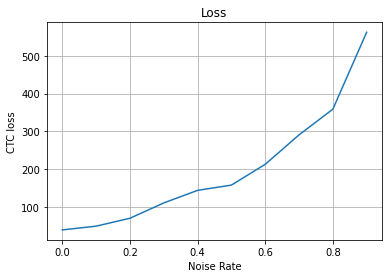

In [126]:
plt.plot(noise_rates, losses)
plt.title("Loss")
plt.xlabel("Noise Rate")
plt.ylabel("CTC loss")
plt.grid()
plt.show()

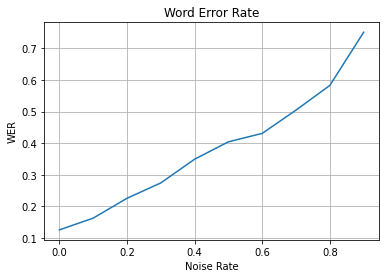

In [127]:
plt.plot(noise_rates, wers)
plt.title("Word Error Rate")
plt.xlabel("Noise Rate")
plt.ylabel("WER")
plt.grid()
plt.show()

### Add Ambulance Sound

#### Visualize Ambulance Sound

In [128]:
#Download heartbeat sound
m.download_url("https://mega.nz/file/E1cREahC#qyQXNSyt8pCgraN9JCatKcqUsydTSHJFOR1jmRJwY0k")
sf, ambulance_sound = wavfile.read("ambulance_sound.wav")

PosixPath('ambulance_sound.wav')

  - Speech audio


  - Transcript: Chief Rowley explained that this would not provide enough additional manpower to take all the measures which he considers required.


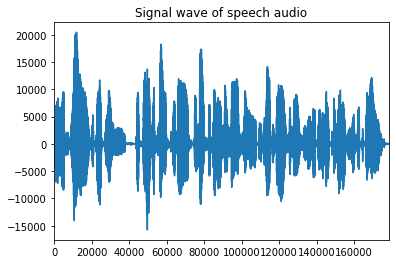

  - Noise audio


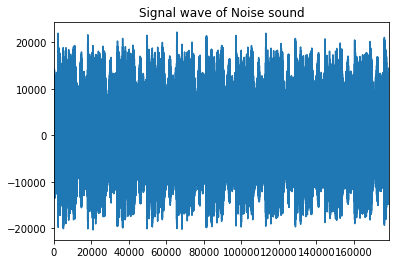

  - Mixed audio with noise_rate = 0.1


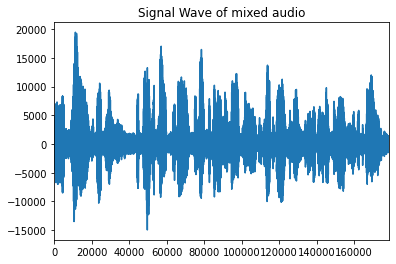

  - Mixed audio with noise_rate = 0.5


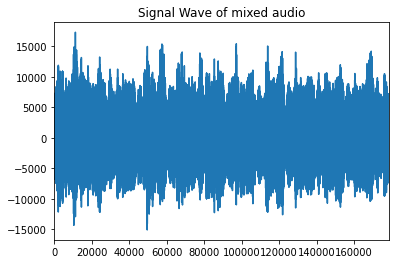

  - Mixed audio with noise_rate = 0.9


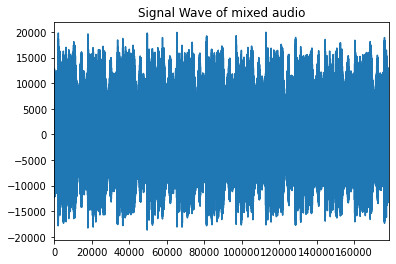

In [140]:
visualization_noise(ambulance_sound)

#### Evaluation

In [132]:
noise_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
losses = []
wers = []
for noise_rate in noise_rates:
  print(f"\033[1m EVALUATE THE MODEL WITH NOISE_RATE = {noise_rate} \033[0m")
  valid_gen_noise = NoiseDataGenerator(df_val, ambulance_sound, noise_rate = noise_rate)
  loss, wer_score = evaluate(model, valid_gen_noise)
  losses.append(loss)
  wers.append(wer_score)
  print("\n")

 EVALUATE THE MODEL WITH NOISE_RATE = 0 
4/4 [==============================] - 9s 2s/step - loss: 39.1392
 CTC LOSS: 39.14 
 WER: 14% 
**********************************************************************
 Transcript:  the secret service should not and does not plan to develop its own intelligence gathering facilities to duplicate the existing facilities of other federal agencies
 prediction:  the secret service should not and does not plan to develop its own intelligence gathering pacilities to duplicate the existing facilities of other federal agencies
**********************************************************************
 Transcript:  although the commission does not know whether the cases involved are entirely comparable
 prediction:  although the commission does not know whether the cases involved aur entirely coparable'
**********************************************************************
 Transcript:  the assistant to the director of the fbi testified that
 prediction:  the a

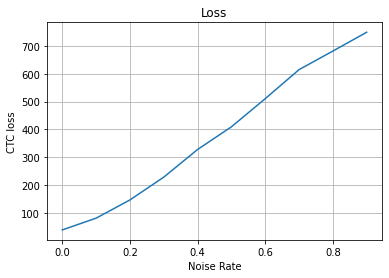

In [133]:
plt.plot(noise_rates, losses)
plt.title("Loss")
plt.xlabel("Noise Rate")
plt.ylabel("CTC loss")
plt.grid()
plt.show()

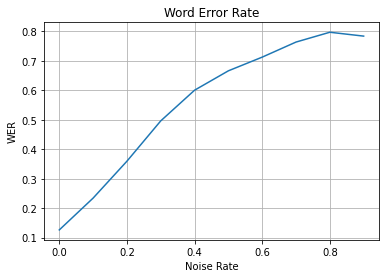

In [134]:
plt.plot(noise_rates, wers)
plt.title("Word Error Rate")
plt.xlabel("Noise Rate")
plt.ylabel("WER")
plt.grid()
plt.show()

# Denoise